In [16]:
import sys
sys.path.append("..") # To get storm code

import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import joblib

from typing import List, Dict

In [17]:
from pymongo import MongoClient

In [18]:
# Internal imports
from src.db import StormDB

sdb = StormDB(MongoClient(host='localhost', port=27017))

In [ ]:
# Configuration
NON_TARGET_SAMPLE_MULTIPLIER = 10
MODEL_NAME = 'simple_track_features' # For use in model registry

# Helper
Not everything exists in the codebase, helper functions that might need to be added in future version will be here

In [19]:
class FeatureSelector(BaseEstimator, TransformerMixin):
        
    def __init__(self, feature_names=[]):
        self.feature_names = feature_names

    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        return X[self.feature_names]

# Preparation
During Storm runs the Weatherboy (instantiated model wrapper) will be handed a list of track ids that need results. It will then on its own have to source the necessary fields, process them and return prediction. **The model pipeline itself starts upon retrieval of the necessary fields.** From there it will be transformed, imputed and scored by the model. This preparation step must be kept minimal, no filtering no transforming, nothing that a simple weatherboy pipeline could not handle and nothing the model is doing.

In [20]:
storm_name = 'film_vg_instrumental_v2'
fields = {'last_updated':0} # The only fields not needed are the metadata for runs

In [21]:
# First grab the targets. These will be 1s in the prediction
target_playlist = sdb.get_config('film_vg_instrumental_v2')['good_targets']
target_track_ids = sdb.get_loaded_playlist_tracks(target_playlist)
target_tracks = sdb.get_track_info(target_track_ids, fields=fields)

In [22]:
# Next we need to get a sample of tracks that are not 1s. For a first pass we will
# grab everything by the artists in the last 5 years. We will sample downstream

artists = []
[artists.extend(track['artists']) for track in target_tracks]

non_target_track_ids = sdb.get_tracks_from_artists(artists, start_date='2017-01-01', end_date='2023-01-01')
non_target_tracks = sdb.get_track_info(non_target_track_ids, fields=fields)

In [23]:
# unify into one dataframe
df = (
    pd.DataFrame.from_records(target_tracks+non_target_tracks)
    .drop_duplicates('_id')
    .set_index('_id')
)

df['target'] = 0
df.loc[df[df.index.isin(target_track_ids)].index, 'target'] = 1

In [24]:
# Create an even sample of tracks, this won't happen during runs
sampled = shuffle(df.groupby('target').head(len(target_track_ids)*NON_TARGET_SAMPLE_MULTIPLIER), random_state=42)
sampled.target.value_counts()

0    233
1    191
Name: target, dtype: int64

# Modeling
We want to try and predict the songs that I like. Out of 25,676, only ~200 are 'great_targets', which is a <.5% discovery rate. Expanding to 'good' targets makes identification easier. Every Transformation will be stored in an SKLearn pipeline for easy saving and loading. 

The Storm has two important functions. 
1. Identify strong tracks for listening - *Identifier*
    - High Precision on liked tracks
    - Meaningful score ranking 


2. Filter weak tracks from listening - *Discriminator*
    - High precision on not liked tracks
    - Scores do not need to be meaningful 

These two models have some overlap but have inherently different goals. Storm is intended to be exhaustive, meaning no music slips through the cracks. This is very hard though as even a small playlist could have hundreds of tracks of a week across all the artists. Filtering the weak tracks out slightly defeats the exhaustiveness, but with tuned filters the user will never miss tracks they like and won't waste time on tracks that won't go anywhere. Identifying strong tracks is intended to start the search and make sure that if every track can't be looked at the ones most likely to be enjoyed take top priority.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(sampled[sampled.columns[:-1]], sampled['target'])

## Identifier
This is prototype of a model pipeline fit and save

In [26]:
model_name = MODEL_NAME+'__identifier' # For use in model registry

model_pipeline = Pipeline([
    ('feature_selection', FeatureSelector(
        feature_names = [
            'duration_ms', 
            'acousticness',
            'danceability', 
            'energy', 
            'instrumentalness', 
            'key',
            'liveness', 
            'loudness', 
            'mode', 
            'speechiness', 
            'tempo',
            'time_signature', 
            'valence'
        ])
    ),
    ('imputer', SimpleImputer(strategy='constant', fill_value=.5)),
    ('clf', tree.DecisionTreeClassifier(
        class_weight={0:.05, 1:.95}, 
        max_depth=8)
    )
])

In [27]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_selection',
                 FeatureSelector(feature_names=['duration_ms', 'acousticness',
                                                'danceability', 'energy',
                                                'instrumentalness', 'key',
                                                'liveness', 'loudness', 'mode',
                                                'speechiness', 'tempo',
                                                'time_signature', 'valence'])),
                ('imputer', SimpleImputer(fill_value=0.5, strategy='constant')),
                ('clf',
                 DecisionTreeClassifier(class_weight={0: 0.05, 1: 0.95},
                                        max_depth=8))])

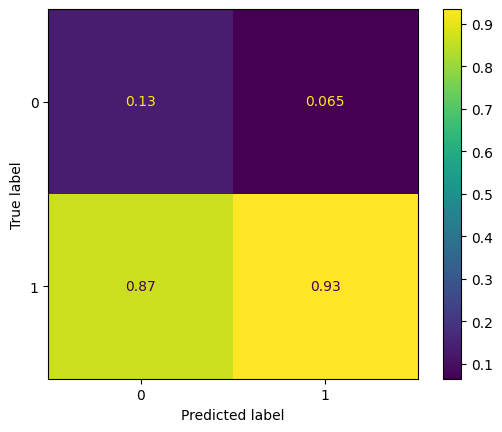

In [28]:
ConfusionMatrixDisplay(confusion_matrix(model_pipeline.predict(X_test), y_test, normalize='pred'), display_labels=model_pipeline.classes_).plot()

In [30]:
# Evulate some labels
sampled['predicted'] = model_pipeline.predict(sampled)

In [46]:
# Saving
joblib.dump(model_pipeline, f'../models/{model_name}.pkl', compress = 1)

['../models/base_all_features__dtc_test.pkl']

In [13]:
# Load and test it can indeed be scored
loaded_pipeline = joblib.load(f'../models/{model_name}.pkl')

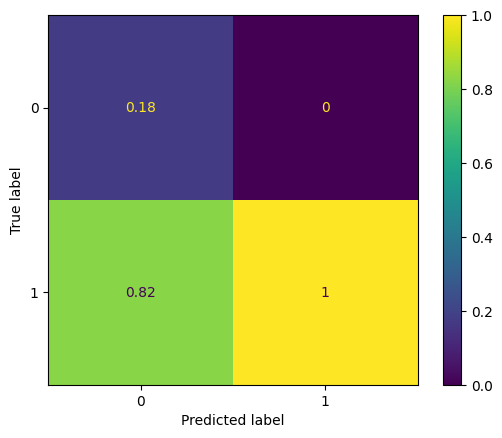

In [15]:
ConfusionMatrixDisplay(confusion_matrix(loaded_pipeline.predict(X_test), y_test, normalize='pred'), display_labels=loaded_pipeline.classes_).plot()